In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
import sys
sys.path.append("./src")

In [2]:
press_path = 'src/_out/PRESS'
encoding = 'ISO-8859-1'

In [3]:
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence

from data.frnewslink import load_article, load_balance_labels
from data.processing_data import tokenize, TK_SEQ, TK_LEMMA, TK_WORD
from model.simple_attention_net import SimpleAttentionNet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML

nlp=spacy.load('fr_core_news_md')

In [7]:
labels = load_balance_labels(annot_path='/Users/dunguyen/Dataset/frnewslink/W07_14/ANNOT_W07_14/', 
                             nb_data_max=1000,
                             press_path='src/_out/PRESS', 
                             cache_dir='src/_out')

Loading row(s): 100%|██████████| 1000/1000 [00:02<00:00, 368.18it/s, neg=500, pos=500]

Save annot labels to src/_out/labels/frnewslink_1000.npy


In [8]:
x1 = []
x2 = []
y = []
lemma1 = []
lemma2 = []

def reduce_labels(labels, nb_data):
    negs = labels[labels[:, 2] == 0]
    pos = labels[labels[:, 2] == 1]
    return np.vstack([negs[:nb_data//2] , pos[:nb_data//2]])

labels = reduce_labels(labels, 10)

for id1, id2, label in labels:
    content = load_article(press_path, id1, encoding)
    seq = tokenize(content, TK_SEQ, nlp)
    lemma1.append(tokenize(content, TK_WORD, nlp))
    x1.append(torch.LongTensor(seq))
    content = load_article(press_path, id2, encoding)
    seq = tokenize(content, TK_SEQ, nlp)
    lemma2.append(tokenize(content, TK_WORD, nlp))
    x2.append(torch.LongTensor(seq))
    y.append(label)
    
x1_pad = pad_sequence(x1)
x2_pad = pad_sequence(x2)

* Load model from **checkpoint**

In [ ]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/SimpleAttentionNet.pt'


embedding = torch.FloatTensor(nlp.vocab.vectors.data)
model = SimpleAttentionNet(embedding.size(0), dim_hidden, embedding)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

* Load model from **best model**

In [12]:
model_path = 'src/_out/models/SimpleAttentionNet.balanced.pt'

dim_hidden = 300
embedding = torch.FloatTensor(nlp.vocab.vectors.data)
model = SimpleAttentionNet(embedding.size(0), dim_hidden, embedding)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Evaluation mode
model.eval()

# Get prediction results
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [13]:
def hightlight_txt(txt, weights):
    max_alpha = 0.9

    highlighted_text = ''
    
    w_min, w_max = torch.min(weights), torch.max(weights)
    w_norm = (weights - w_min)/(w_max - w_min)
    
    for i in range(len(txt)):
        highlighted_text+= '<span style="background-color:rgba(135,206,250,' \
                                + str(float(w_norm[i]) / max_alpha) + ');">' \
                                + txt[i] + '</span> '
      
    #display(HTML(highlighted_text))
    return highlighted_text

def visualize(lemma1, lemma2, attention1, attention2, pred):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td></tr>'
    html += '</table>'
    return html

In [14]:
display(len(lemma1[0]))
display(a2v1[0].size())

140

torch.Size([415])

In [ ]:
x1[0]

In [15]:
text = visualize(lemma1, lemma2, a2v1, a1v2, preds)
display(HTML(text))

Plot attention values

In [16]:
plt.plot(a1v2[0].numpy())

In [17]:
plt.plot(a2v1[0].numpy())

In [13]:
from py_data.frnewslink import load_balance_labels

### Test confusion matrix

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
import sys
sys.path.append("./src")

In [3]:
import torch
from src.helpers.trainer_score import Scorer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
scorer = Scorer(['confusion_matrix'], n_class=3)

In [5]:
y_true = torch.Tensor([0,1,2,0,1])
y_pred = torch.Tensor([[.8,.1,.1],
                       [.2, .5, .3],
                       [.1, .7, .2],
                       [.1, .3, .6],
                       [.2, .2, .6]])

In [6]:
scorer(y_pred, y_true.int())

{}

In [7]:
s = scorer.compute()
s['confusion_matrix']

[[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 1.0, 0.0]]

In [8]:
cfm = s['confusion_matrix']
classes = ["neutral", "entailment", "contradiction"]
df = pd.DataFrame(cfm, index = classes, columns = classes)

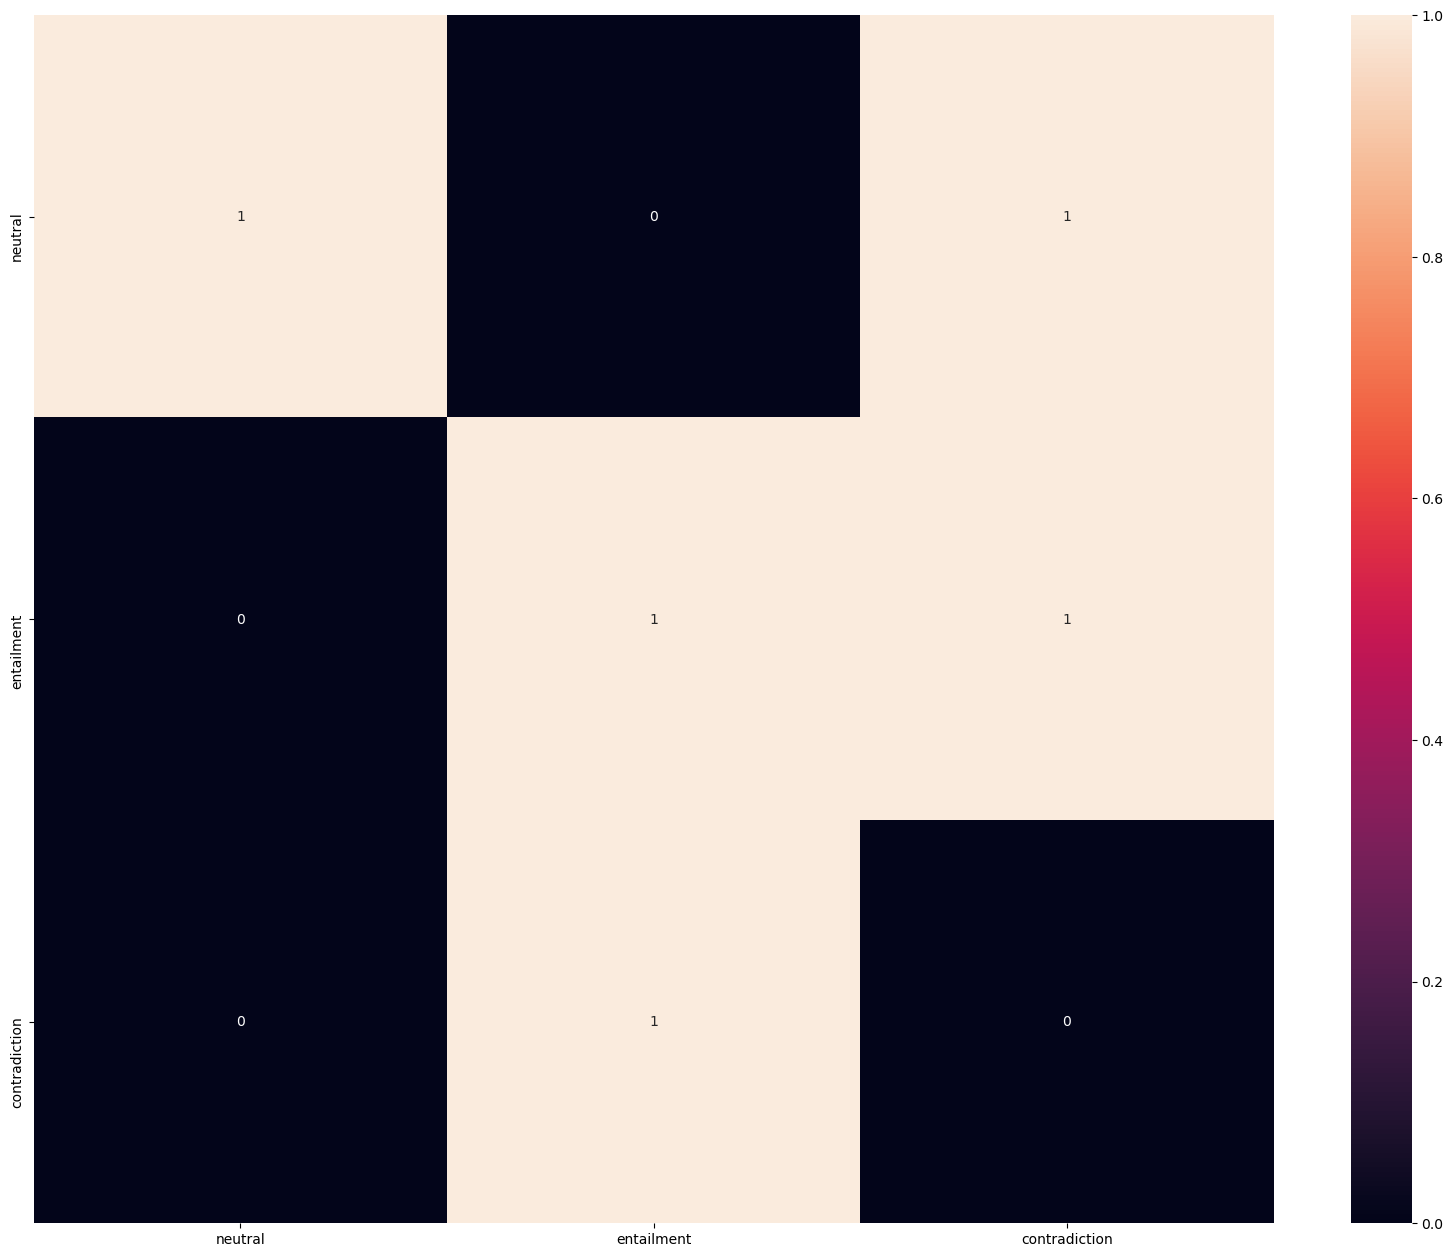

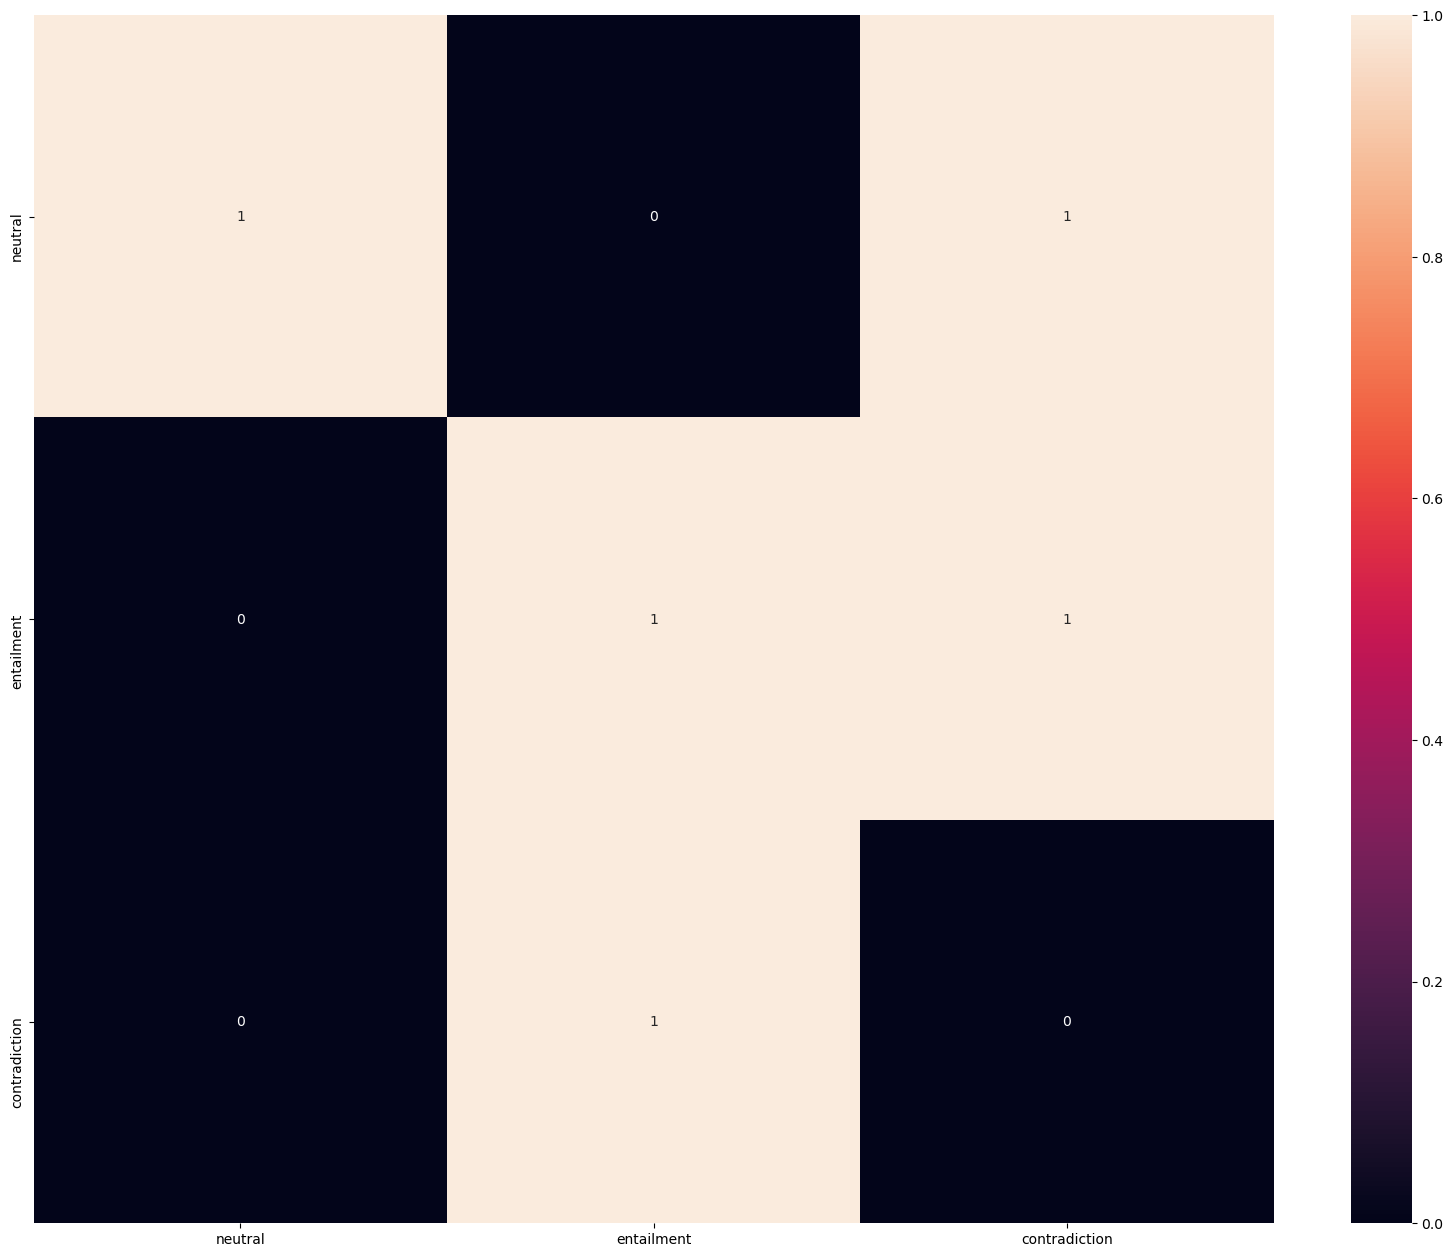

In [17]:
plt.figure(figsize = (10,8), dpi=100)
cfm_plot = sn.heatmap(df, annot=True)

In [18]:
modelname = 'SimpleAttentionNet.balanced'

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [20]:
summary = SummaryWriter('src/_out/logs/'+modelname)
summary.add_figure('confusion_matrix', cfm_plot.figure, global_step=10)